In [1]:
from pathlib import Path
import sys, os

# 1. cwd is project-root/examples
cwd = Path().resolve()
# 2. project-root is its parent
project_root = cwd.parent

# 3. add project_root to sys.path
sys.path.insert(0, str(project_root))

# debug: make sure 'examples' shows up
# print("PYTHONPATH entries:")
# for p in sys.path[:3]:
#     print(" ", p)
# print("project_root contents:", os.listdir(project_root))

import fire
import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from pytagi import HRCSoftmaxMetric, Utils, exponential_scheduler
from examples.tagi_resnet_model import resnet18_cifar10


In [2]:
torch.manual_seed(17)

# Constants for dataset normalization
NORMALIZATION_MEAN = [0.4914, 0.4822, 0.4465]
NORMALIZATION_STD = [0.2470, 0.2435, 0.2616]

def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images to shape (B*C*H*W,)
    batch_images = batch_images.reshape(-1)

    # Convert to numpy arrays
    batch_images = batch_images.numpy()
    batch_labels = batch_labels.numpy()

    return batch_images, batch_labels


def load_datasets(batch_size: int, framework: str = "tagi"):
    """Load and transform CIFAR10 training and test datasets."""
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD),
        ]
    )

    train_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=True, download=True, transform=transform_train
    )
    test_set = torchvision.datasets.CIFAR10(
        root="../data/cifar", train=False, download=True, transform=transform_test
    )


    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        collate_fn=custom_collate_fn,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        collate_fn=custom_collate_fn,
    )

    return train_loader, test_loader


In [3]:
images = {}
m_preds = {}
v_preds = {}
v_preds_epistemic = {}
v_preds_aleatoric = {}



def tagi_trainer(
    num_epochs: int,
    batch_size: int,
    device: str,
    sigma_v: float,
):
    """
    Run classification training on the Cifar dataset using a custom neural model.

    Parameters:
    - num_epochs: int, number of epochs for training
    - batch_size: int, size of the batch for training
    """
    utils = Utils()
    train_loader, test_loader = load_datasets(batch_size, "tagi")

    # Hierachical Softmax
    metric = HRCSoftmaxMetric(num_classes=10)
    nb_classes = 10

    # Resnet18
    net = resnet18_cifar10(gain_w=0.083, gain_b=0.083)
    net.to_device(device)

    epoch = 1
    count = 0

    net.load("../models_bin/cifar_resnet_50_logits_10.bin")

    # Testing
    test_error = 0
    num_test_samples = 0
    net.eval()
    for x, labels in test_loader:
        x = x.flatten()
        m_pred, v_pred = net(x)

        print(f"m_pred" f"{m_pred}")
        print(f"v_pred" f"{v_pred}")

        v_pred_epi = v_pred[::2]
        v_pred_ale = m_pred[1::2]
        v_pred = v_pred[::2] + m_pred[1::2]
        m_pred = m_pred[::2]

        for i in range(len(labels)):
            images[count] = x[i * 1024 * 3 : (i + 1) * 1024 * 3]
            m_preds[count] = m_pred[i * 10 : (i + 1) * 10]
            v_preds[count] = v_pred[i * 10 : (i + 1) * 10]
            v_preds_epistemic[count] = v_pred_epi[i * 10 : (i + 1) * 10]
            v_preds_aleatoric[count] = v_pred_ale[i * 10 : (i + 1) * 10]
            count += 1


        # Calculate test error
        pred = np.reshape(m_pred, (len(labels), 10))
        label = np.argmax(pred, axis=1)
        test_error += np.sum(label != labels)
        num_test_samples += len(labels)

    test_error_rate = (test_error / num_test_samples) * 100
    print(
        f"\nEpoch {epoch+1}/{num_epochs}: "
        f"Test Error: {test_error_rate:.2f}%"
    )


In [4]:
framework = "tagi"
batch_size = 128
epochs = 50
device = "cuda"
sigma_v = 0.05


tagi_trainer(
    batch_size=batch_size, num_epochs=epochs, device=device, sigma_v=sigma_v
)

Files already downloaded and verified
Files already downloaded and verified
m_pred[ -9.422117    0.7696746  -9.728991  ...   1.0122541 -10.408587
   1.869696 ]
v_pred[5.27716438e-05 1.15250965e-04 5.29700919e-05 ... 1.03215731e-04
 4.14374008e-05 3.62969586e-04]
m_pred[ -8.630283     1.6481761  -10.309927   ...   1.8911442  -10.851364
   0.55511904]
v_pred[4.8510952e-05 4.2745582e-04 4.3328528e-05 ... 1.0615947e-03 6.4850909e-05
 9.3564537e-05]
m_pred[ -9.534511    1.34717   -10.105677  ...   1.7874241   3.409997
  17.775505 ]
v_pred[5.1163865e-05 3.6173550e-04 4.9855556e-05 ... 5.7471765e-04 1.2507685e-04
 5.8571238e-02]
m_pred[ -9.89272      0.49254817 -10.11359    ...   0.1671769  -10.421732
   0.2657312 ]
v_pred[8.4913809e-05 8.4708474e-05 8.9597183e-05 ... 1.3956387e-05 7.7077377e-05
 3.6187834e-05]
m_pred[ -9.218719     0.15450594 -10.360739   ...   0.86132544  -9.564722
   1.1766886 ]
v_pred[1.7529370e-04 1.8158888e-05 1.4967202e-04 ... 8.4194086e-05 4.6960977e-05
 1.6291093e-04

v_preds_epistemic 0 [5.2771644e-05 5.2970092e-05 6.6648383e-05 1.1657264e-04 5.5357934e-05
 8.1322287e-05 5.9597420e-05 7.5677039e-05 6.4882966e-05 6.3995853e-05]
v_preds_aleatoric 0 [ 0.7696746   0.87072414  3.5321562  33.345543    0.8199731  10.954697
  3.8354473   2.2288082   0.4195048   0.65293217]
v_preds 0 [ 0.76972735  0.87077713  3.532223   33.34566     0.8200285  10.954778
  3.835507    2.2288837   0.41956967  0.6529962 ]


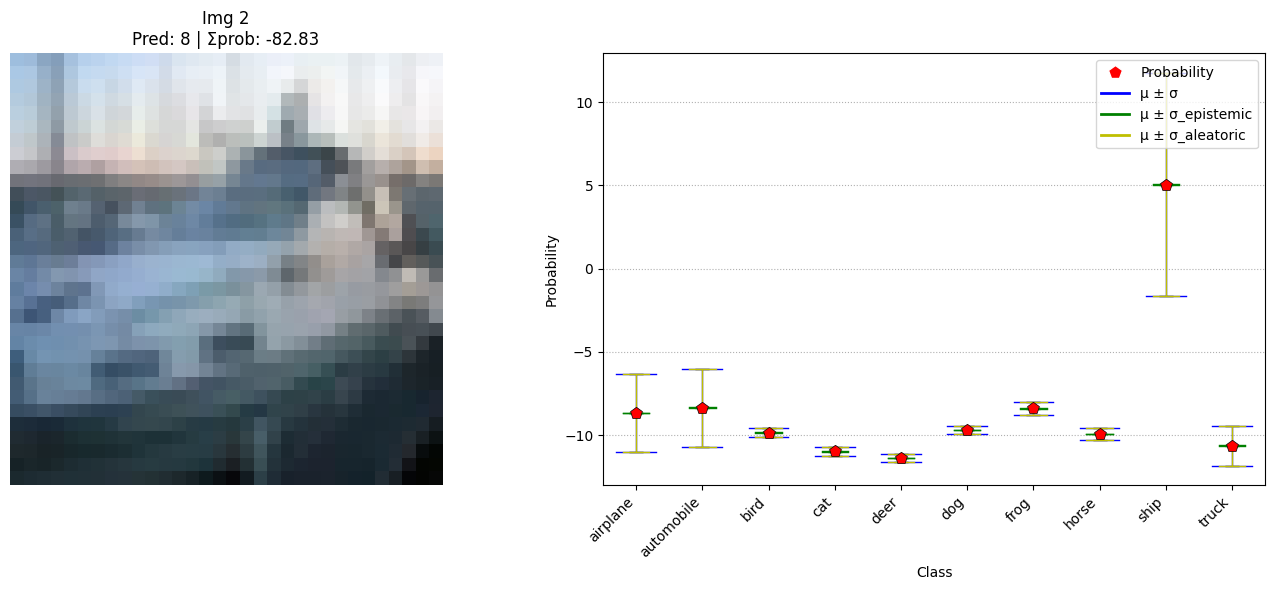

In [ ]:
import matplotlib.pyplot as plt

def plot_class_uncertainty(image_idx, images, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric, delta=0.3):
    """
    Plots CIFAR-10 images with class probabilities and uncertainties.
    """
    # 1. Fix image preprocessing for CIFAR-10
    img = images[image_idx]
    img = img.reshape(3, 32, 32).transpose(1, 2, 0)

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Denormalize if using standard CIFAR normalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure valid pixel range

    # 2. Handle probabilistic outputs
    means = m_preds[image_idx]
    stds = np.sqrt(v_preds[image_idx])
    stds_epistemic = np.sqrt(v_preds_epistemic[image_idx])
    stds_aleatoric = np.sqrt(v_preds_aleatoric[image_idx])
    classes = np.arange(10)

    # 3. Create figure
    fig, (ax_img, ax_probs) = plt.subplots(1, 2, figsize=(14, 6))

    # Image plot (CIFAR-10 specific)
    ax_img.imshow(img)
    ax_img.set_title(f'Img {image_idx}\nPred: {np.argmax(means)} | Σprob: {np.sum(means):.2f}')
    ax_img.axis('off')

    # Probability plot with error bars
    for i in classes:
        delta = 0.3
        # Vertical uncertainty bars
        ax_probs.errorbar(i, means[i], yerr=stds[i],
                         fmt='none', ecolor='b', elinewidth=1, capsize=5)

        # Horizontal caps
        ax_probs.plot([i-delta, i+delta], [means[i]+stds[i], means[i]+stds[i]],
                     'b', linewidth=1)
        ax_probs.plot([i-delta, i+delta], [means[i]-stds[i], means[i]-stds[i]],
                     'b', linewidth=1)

        delta = 0.2
        # Aleatoric uncertainty
        ax_probs.errorbar(i, means[i], yerr=stds_aleatoric[i],
                         fmt='none', ecolor='y', elinewidth=1, capsize=5)

        # Horizontal caps
        ax_probs.plot([i-delta, i+delta], [means[i]+stds_aleatoric[i], means[i]+stds_aleatoric[i]],
                     'y', linewidth=1)
        ax_probs.plot([i-delta, i+delta], [means[i]-stds_aleatoric[i], means[i]-stds_aleatoric[i]],
                        'y', linewidth=1)

        # delta = 0.1
        # Epistemic uncertainty
        ax_probs.errorbar(i, means[i], yerr=stds_epistemic[i],
                         fmt='none', ecolor='g', elinewidth=1, capsize=5)


        # Horizontal caps
        ax_probs.plot([i-delta, i+delta], [means[i]+stds_epistemic[i], means[i]+stds_epistemic[i]],
                     'g', linewidth=1)
        ax_probs.plot([i-delta, i+delta], [means[i]-stds_epistemic[i], means[i]-stds_epistemic[i]],
                        'g', linewidth=1)


        # Scatter points
        ax_probs.scatter(i, means[i], color='r', marker='p', s=80,
                        zorder=3, edgecolor='k', linewidth=0.5)

     # Replace numeric x-axis with class names
    ax_probs.set_xticks(classes)
    ax_probs.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)

    # Adjust spacing to accommodate rotated labels
    plt.subplots_adjust(bottom=0.15)

    ax_probs.set_xlim(-0.5, 9.5)
    # ax_probs.set_ylim(0, 1.1)  # Adjusted for probability range
    ax_probs.grid(True, axis='y', linestyle=':')
    ax_probs.set_xlabel('Class')
    ax_probs.set_ylabel('Probability')

    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='p', color='w', label='Probability',
              markerfacecolor='r', markersize=10),
        Line2D([0], [0], color='b', lw=2, label='μ ± σ'),
        Line2D([0], [0], color='g', lw=2, label='μ ± σ_epistemic'),
        Line2D([0], [0], color='y', lw=2, label='μ ± σ_aleatoric')
    ]
    ax_probs.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

print("v_preds_epistemic 0", v_preds_epistemic[0])
print("v_preds_aleatoric 0", v_preds_aleatoric[0])
print("v_preds 0", v_preds[0])

plot_class_uncertainty(0, images, m_preds, v_preds, v_preds_epistemic, v_preds_aleatoric)